In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from config.defaults import cfg
import torch
from torchvision.ops import masks_to_boxes
import matplotlib.patches as patches

In [2]:
cfg.DATASET.IMAGE_10K_ROOT

'images/10k/bdd100k/images/10k'

In [3]:
root = '../'+cfg.DATASET.ROOT
images100k_root = os.path.join(root, cfg.DATASET.IMAGE_ROOT, 'train')
images10k_root = os.path.join(root, cfg.DATASET.IMAGE_10K_ROOT, 'train')
drivable_area_root = os.path.join(root, cfg.DATASET.DRIVABLE_AREA_MASK, 'train')
ins_root = os.path.join(root, cfg.DATASET.INSTANCE_SEGMENTATION_ROOT, 'train')

In [4]:
images100k = os.listdir(images100k_root)
images10k = os.listdir(images10k_root)
drivable_mask = os.listdir(drivable_area_root)
ins_masks = os.listdir(ins_root)

In [6]:
print(f"{len(images10k)} images, {len(drivable_mask)} drivable area masks and {len(ins_masks)} instance masks.")

7000 images, 70000 drivable area masks and 7000 instance masks.


In [7]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [8]:
intersection_images = intersection(drivable_mask, ins_masks )

In [9]:
len(intersection_images)

2976

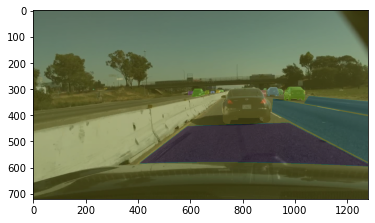

In [10]:
idx = random.randint(0, len(intersection_images))
image = Image.open(os.path.join(images10k_root, intersection_images[idx].replace('.png','.jpg')))
drivable_area_mask =  Image.open(os.path.join(drivable_area_root, intersection_images[idx]))
instance_mask = Image.open(os.path.join(ins_root, intersection_images[idx]))

plt.imshow(image)
plt.imshow(drivable_area_mask, alpha=0.3)
plt.imshow(instance_mask, alpha=0.3)
plt.show()

## Exploring the Json Files

In [11]:
import json

## Polygon

In [17]:
polygon_path = os.path.join(root, 'labels/ins_seg/polygons/ins_seg_train.json')
with open(polygon_path, 'r') as f:
    polygon_annotation = json.load(f)

In [21]:
polygon_annotation[0].keys()

dict_keys(['name', 'labels'])

In [22]:
polygon_annotation[0]['name']

'6b73ccdd-00000000.jpg'

[ 0  1  2  3  4  5  6  7  8  9 10 11]
(720, 1280)


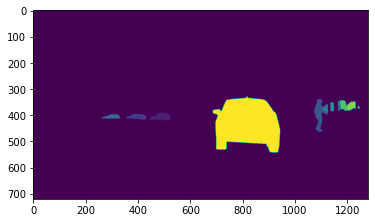

In [74]:
mask = Image.open(os.path.join(ins_root, polygon_annotation[0]['name'].replace('.jpg', '.png')))
mask = np.array(mask)
plt.imshow(mask)
print(np.unique(mask))
print(mask.shape)

In [75]:
mask.shape

(720, 1280)

In [110]:
def to_mask(mask_shape, p):
    
    nx, ny = mask_shape[1], mask_shape[0]
    poly_verts = p

    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x,y)).T

    path = Path(poly_verts)
    grid = path.contains_points(points)
    grid = grid.reshape((ny,nx))

    return grid

In [111]:
def extract_bbox_from_mask(mask):
    """
    Function to extract bounding boxes from masks
    :param mask_path: str, path for the mask
    :return: Tensor contains the bounding boxes
    """
    mask = torch.tensor(mask, dtype=torch.uint8)  # read the mask as a tensor type
    obj_ids = torch.unique(mask)  # get the unique colors
    obj_ids = obj_ids[1:]  # get rid of the last color which is 2 (in my case 2 is the background)

    masks = mask == obj_ids[:, None, None]  # split the color-encoded mask into a set of boolean masks.
    boxes = masks_to_boxes(masks)  # get the bounding boxes

    return boxes

In [130]:
labels = []
for pol in polygon_annotation[0]['labels']:
    p = pol['poly2d'][0]['vertices']
    mask = to_mask(mask.shape, p)
    box = extract_bbox_from_mask(mask)
    labels.append({
        'mask': mask,
        'box': box,
    })

In [131]:
labels

[{'mask': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'box': tensor([[448., 393., 524., 421.]])},
 {'mask': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'box': tensor([[357., 396., 432., 416.]])},
 {'mask': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., Fals

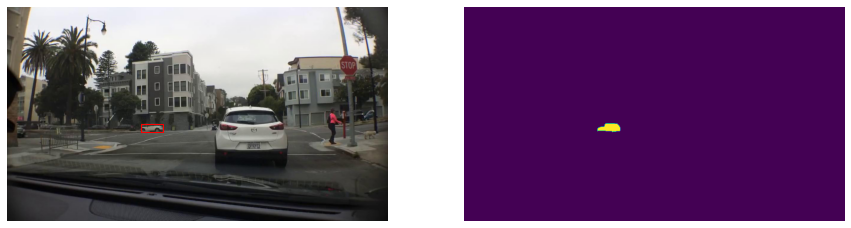

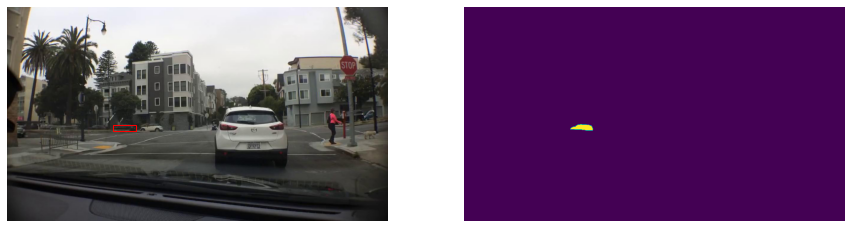

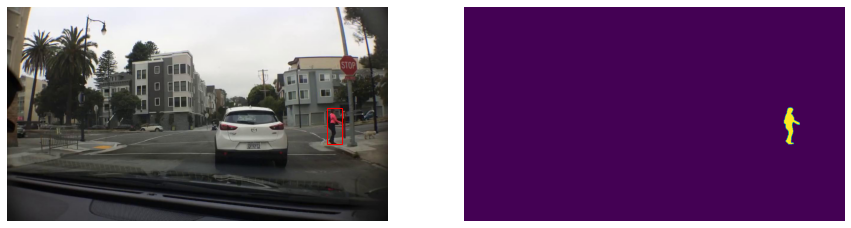

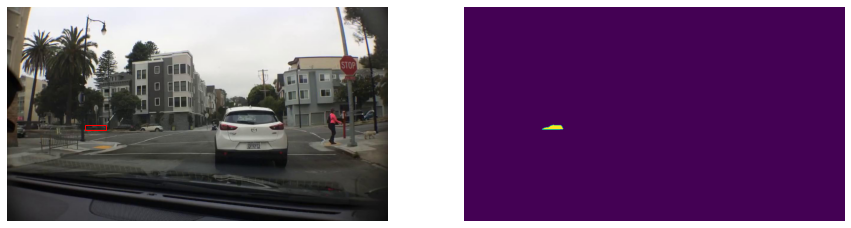

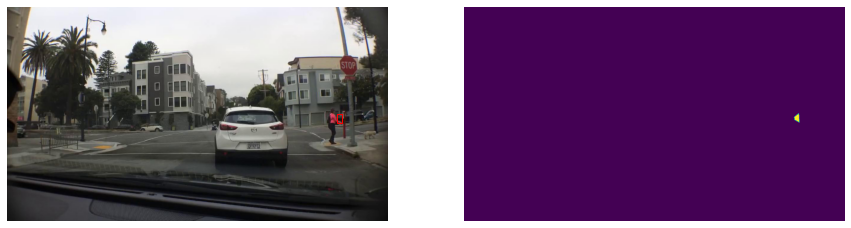

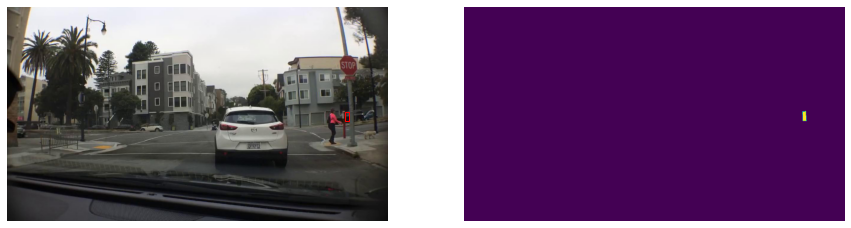

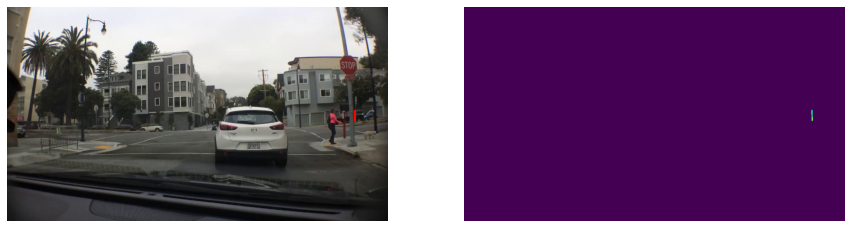

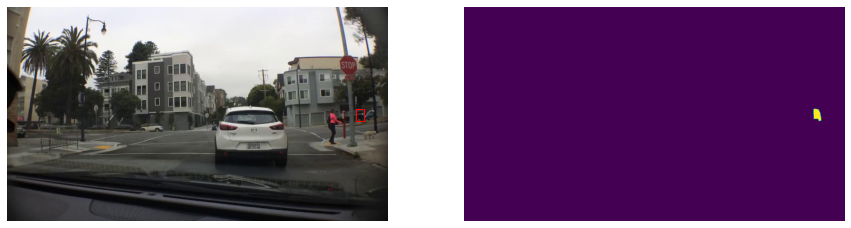

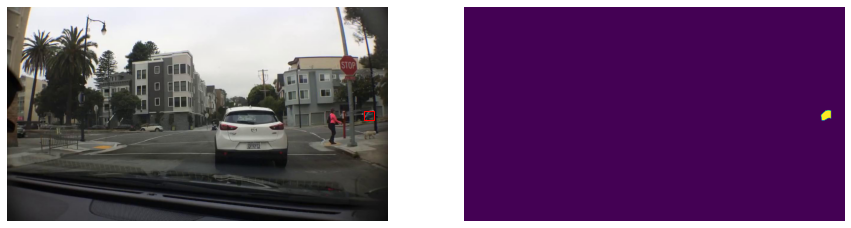

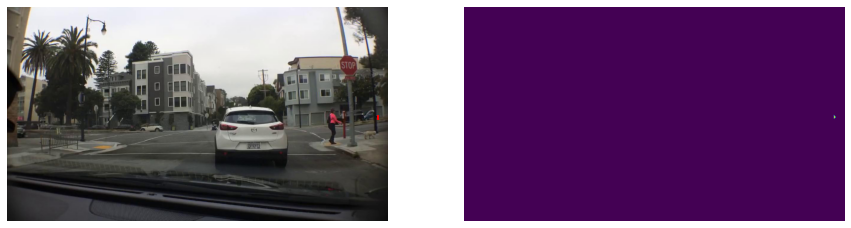

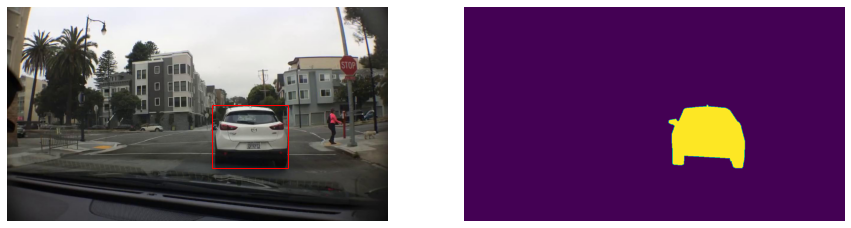

In [133]:
image = Image.open(os.path.join(images10k_root, polygon_annotation[0]['name']))
for label in labels:
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image)
    bbox = label['box'][0]
    mask = label['mask']
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                         edgecolor='red',
                                         facecolor="none", linewidth=1)
    ax[0].add_patch(rect)

    ax[1].imshow(mask)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()